In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


In [2]:
%matplotlib inline

In [3]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob
import flammkuchen as fl
import shutil
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

In [4]:
from scipy.signal import savgol_filter

def smooth_trace(trace, wnd=6, poly=2):
    return savgol_filter(trace, wnd, poly)  # window size 5, polynomial order 2


In [5]:
def process_data(tail, i_fins, c_fins, laterality):
    print(tail.shape)

    # Reshape `laterality` to be a column vector for broadcasting
    laterality = laterality.reshape(-1, 1)

    # Apply transformations based on laterality
    tails = tail * laterality
    ipsilateral_fins = i_fins * -laterality
    contralateral_fins = c_fins * laterality

    print(tails.shape)  # This should match the input shape

    return tails, ipsilateral_fins, contralateral_fins


In [6]:


def filter_trials(tails, ipsilateral_fins, contralateral_fins, threshold, baseline_points=5, max_threshold_factor=1.5):
    """
    Filters trials where both the start and end points have an absolute mean below a threshold,
    and removes tails whose maximum point is significantly larger than the mean maximum of all traces.
    
    Parameters:
    - tails, ipsilateral_fins, contralateral_fins: 2D numpy arrays where each row is a trace.
    - threshold: The threshold value to compare against.
    - baseline_points: Number of timepoints to consider for baseline calculation (default is 5).
    - max_threshold_factor: The factor above the mean maximum value to consider as significantly larger (default is 1.5).
    
    Returns:
    - Filtered 2D numpy arrays of tails, ipsilateral_fins, and contralateral_fins.
    - A boolean mask (`final_mask_trials`) indicating which original trials passed the filtering.
    """
    
    # Calculate the absolute mean for start and end points of the baseline
    baseline_start_tails = np.mean(np.abs(tails[:, :baseline_points]), axis=1)
    baseline_end_tails = np.mean(np.abs(tails[:, -baseline_points:]), axis=1)
    
    baseline_start_ipsi = np.mean(np.abs(ipsilateral_fins[:, :baseline_points]), axis=1)
    baseline_end_ipsi = np.mean(np.abs(ipsilateral_fins[:, -baseline_points:]), axis=1)
    
    baseline_start_contra = np.mean(np.abs(contralateral_fins[:, :baseline_points]), axis=1)
    baseline_end_contra = np.mean(np.abs(contralateral_fins[:, -baseline_points:]), axis=1)

    # Determine which trials pass the baseline threshold condition for both start and end
    valid_baseline_tails = (baseline_start_tails <= threshold) & (baseline_end_tails <= threshold)
    valid_baseline_ipsi = (baseline_start_ipsi <= threshold) & (baseline_end_ipsi <= threshold)
    valid_baseline_contra = (baseline_start_contra <= threshold) & (baseline_end_contra <= threshold)

    # Combine all baseline masks to filter the entire trial
    initial_valid_mask = valid_baseline_tails & valid_baseline_ipsi & valid_baseline_contra

    # Filter all traces by the combined initial mask
    filtered_tails = tails[initial_valid_mask]
    filtered_ipsilateral_fins = ipsilateral_fins[initial_valid_mask]
    filtered_contralateral_fins = contralateral_fins[initial_valid_mask]

    # Calculate the mean maximum of all valid tails
    if filtered_tails.size > 0:
        mean_max_tails = np.mean(np.max(filtered_tails, axis=1))
        significant_max_threshold = mean_max_tails * max_threshold_factor

        # Remove tails whose maximum point is significantly larger than the mean maximum
        valid_max_mask_tails = np.max(filtered_tails, axis=1) <= significant_max_threshold

        # Apply this mask to the initially filtered data
        final_valid_mask = initial_valid_mask.copy()
        final_valid_mask[initial_valid_mask] = valid_max_mask_tails
    else:
        # In case no trials pass the initial filtering, all are invalid
        final_valid_mask = np.full(tails.shape[0], False)

    # Apply final masks to traces
    filtered_tails = tails[final_valid_mask]
    filtered_ipsilateral_fins = ipsilateral_fins[final_valid_mask]
    filtered_contralateral_fins = contralateral_fins[final_valid_mask]

    return filtered_tails, filtered_ipsilateral_fins, filtered_contralateral_fins, final_valid_mask




### Load data

In [7]:
master_path = Path(r"\\portulab.synology.me\data\Kata\Data\230307_visstim_2D") #rectangular arena # start from fish 1
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_round")
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_2") #rectangular arena
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\13052024_visstim_2D_round")
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\14052024_visstim_2D_round")

fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)

([WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/105646_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/110659_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/111701_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/112901_f1'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/113916_f2'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/114946_f2'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120350_f3'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/123953_f4'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/125639_f5'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/130839_f5'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/13204

In [8]:
fish= 3
fish_id =  fish_paths[fish].name
exp_name = Path(fish_paths[fish]).parts[-2]
fish_id, exp_name


('112901_f1', '230307_visstim_2D')

In [9]:
out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\230307_visstim_2D_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_round_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_2_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\13052024_visstim_2D_round_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\14052024_visstim_2D_round_")

## Load data all

In [10]:
plot =True
threshold_value = 0.15
max_threshold_factor = 2  # Example factor to define "significantly larger"

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

Working on fish 105646_f0
(47, 3, 50)
(47, 50)
(47, 50)


  8%|██████▍                                                                            | 1/13 [00:00<00:05,  2.17it/s]

 total bouts 47
 Bouts filtered 8
 bouts keps 39
Working on fish 110659_f0
(68, 3, 50)
(68, 50)
(68, 50)


 15%|████████████▊                                                                      | 2/13 [00:00<00:04,  2.35it/s]

 total bouts 68
 Bouts filtered 9
 bouts keps 59
Working on fish 111701_f0
(6, 3, 50)
(6, 50)
(6, 50)


 23%|███████████████████▏                                                               | 3/13 [00:01<00:04,  2.47it/s]

 total bouts 6
 Bouts filtered 5
 bouts keps 1
Working on fish 112901_f1
(189, 3, 50)
(189, 50)
(189, 50)


 31%|█████████████████████████▌                                                         | 4/13 [00:01<00:03,  2.37it/s]

 total bouts 189
 Bouts filtered 147
 bouts keps 42
Working on fish 113916_f2
(212, 3, 50)
(212, 50)
(212, 50)


 38%|███████████████████████████████▉                                                   | 5/13 [00:02<00:03,  2.04it/s]

 total bouts 212
 Bouts filtered 105
 bouts keps 107
Working on fish 114946_f2
(243, 3, 50)
(243, 50)
(243, 50)


 46%|██████████████████████████████████████▎                                            | 6/13 [00:02<00:03,  1.83it/s]

 total bouts 243
 Bouts filtered 116
 bouts keps 127
Working on fish 120328_f3
(361, 3, 50)
(361, 50)
(361, 50)


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:03<00:03,  1.54it/s]

 total bouts 361
 Bouts filtered 42
 bouts keps 319
Working on fish 120350_f3
(242, 3, 50)
(242, 50)
(242, 50)


 62%|███████████████████████████████████████████████████                                | 8/13 [00:04<00:03,  1.50it/s]

 total bouts 242
 Bouts filtered 58
 bouts keps 184
Working on fish 123953_f4
(64, 3, 50)
(64, 50)
(64, 50)


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:04<00:02,  1.73it/s]

 total bouts 64
 Bouts filtered 13
 bouts keps 51
Working on fish 125639_f5
(213, 3, 50)
(213, 50)
(213, 50)


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:05<00:01,  1.77it/s]

 total bouts 213
 Bouts filtered 68
 bouts keps 145
Working on fish 130839_f5
(362, 3, 50)
(362, 50)
(362, 50)


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:06<00:01,  1.51it/s]

 total bouts 362
 Bouts filtered 99
 bouts keps 263
Working on fish 132040_f6
(315, 3, 50)
(315, 50)
(315, 50)


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:06<00:00,  1.52it/s]

 total bouts 315
 Bouts filtered 35
 bouts keps 280
Working on fish 133118_f6
(354, 3, 50)
(354, 50)
(354, 50)


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]

 total bouts 354
 Bouts filtered 47
 bouts keps 307


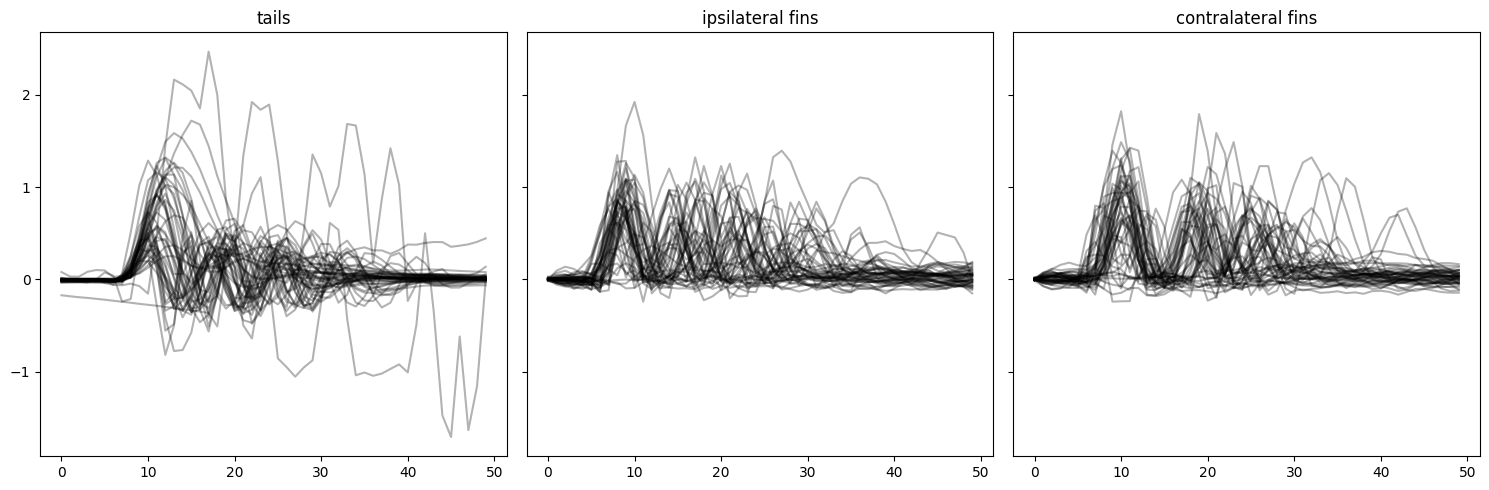

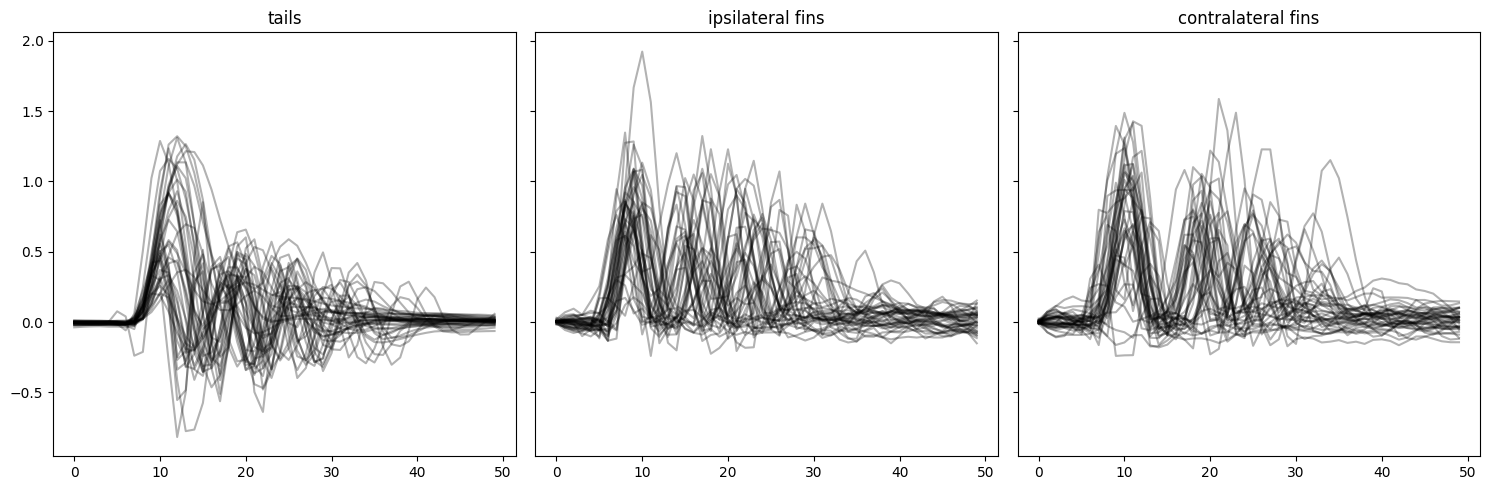

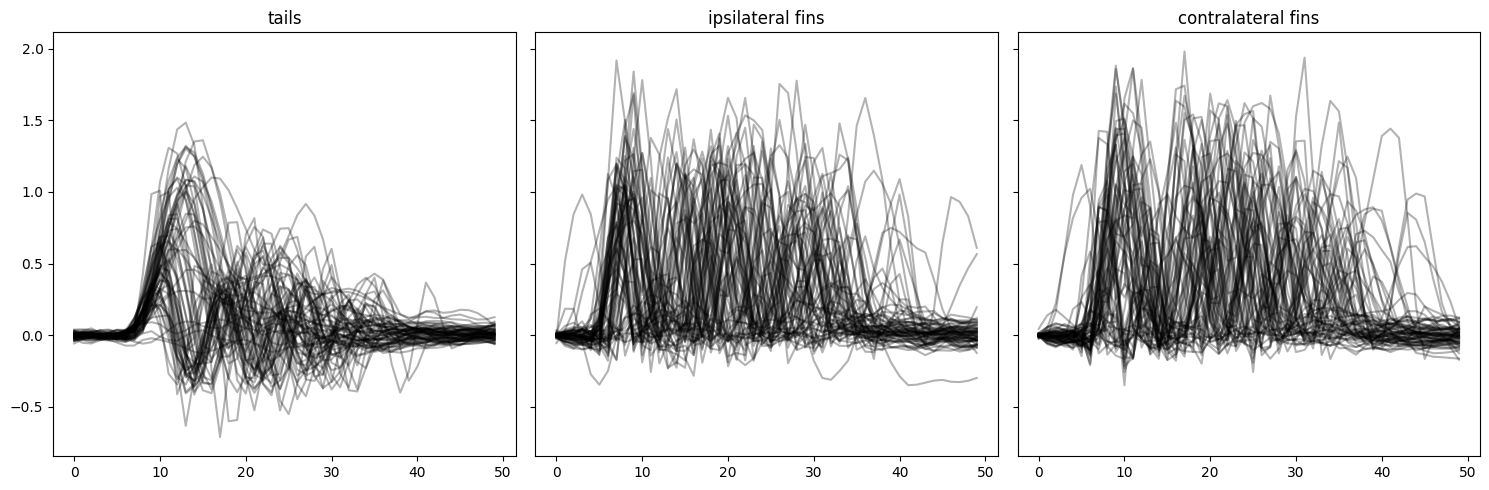

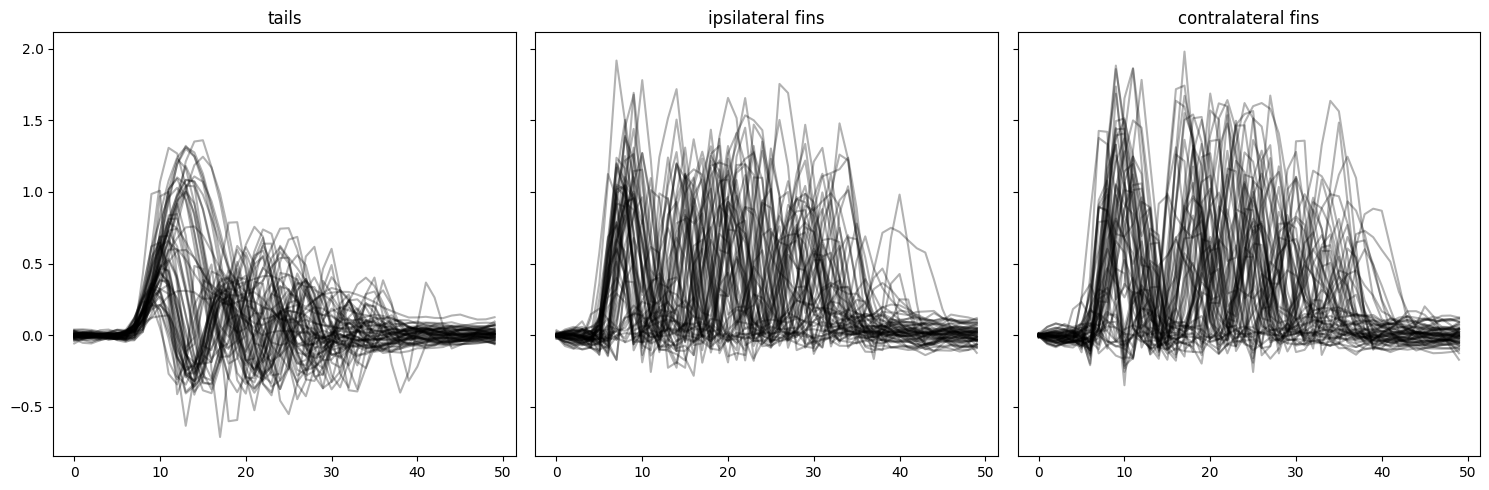

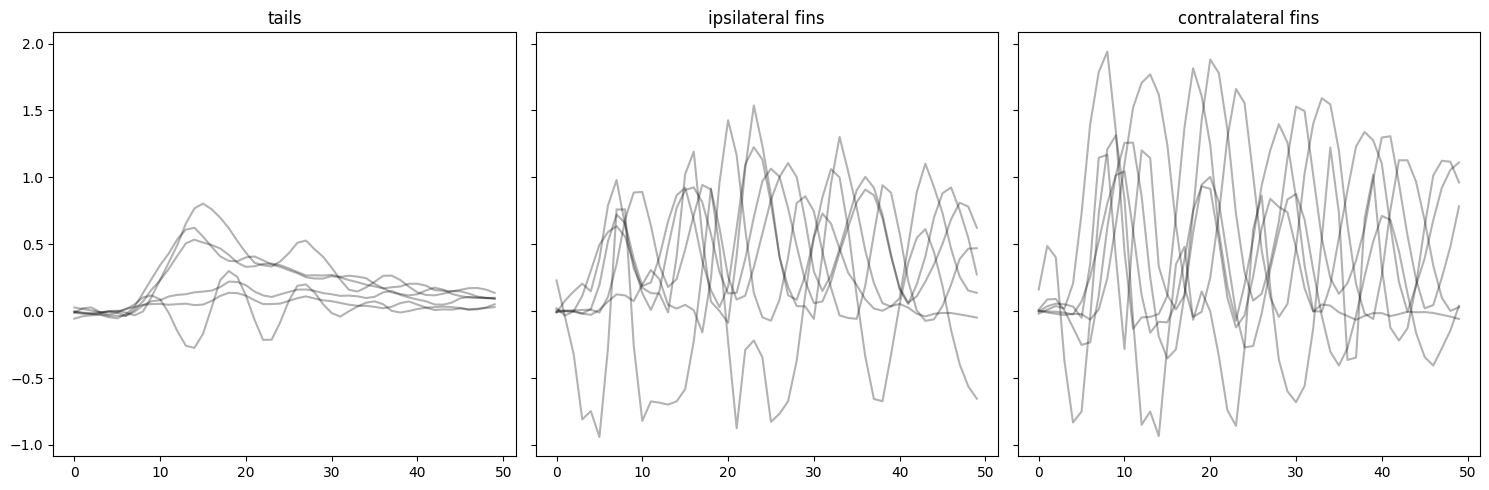

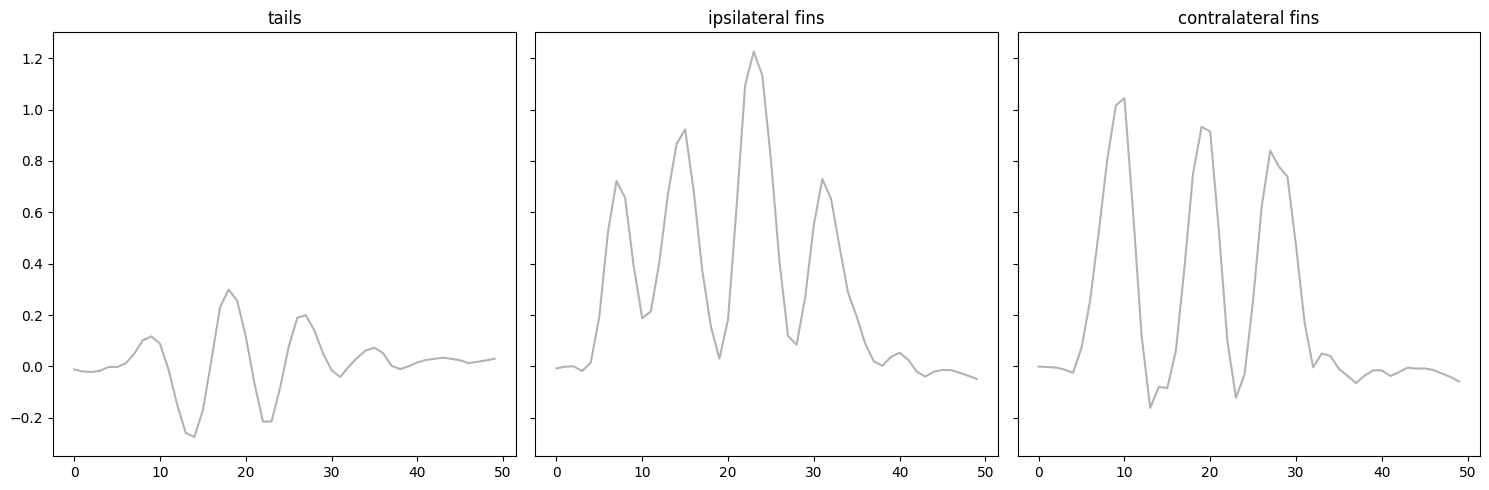

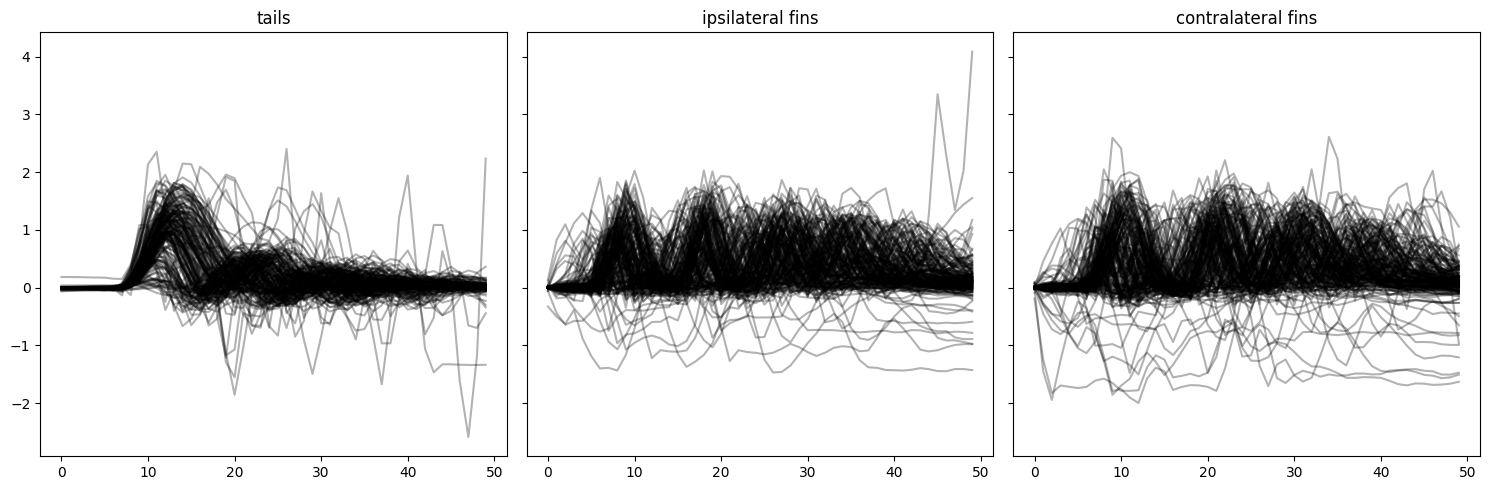

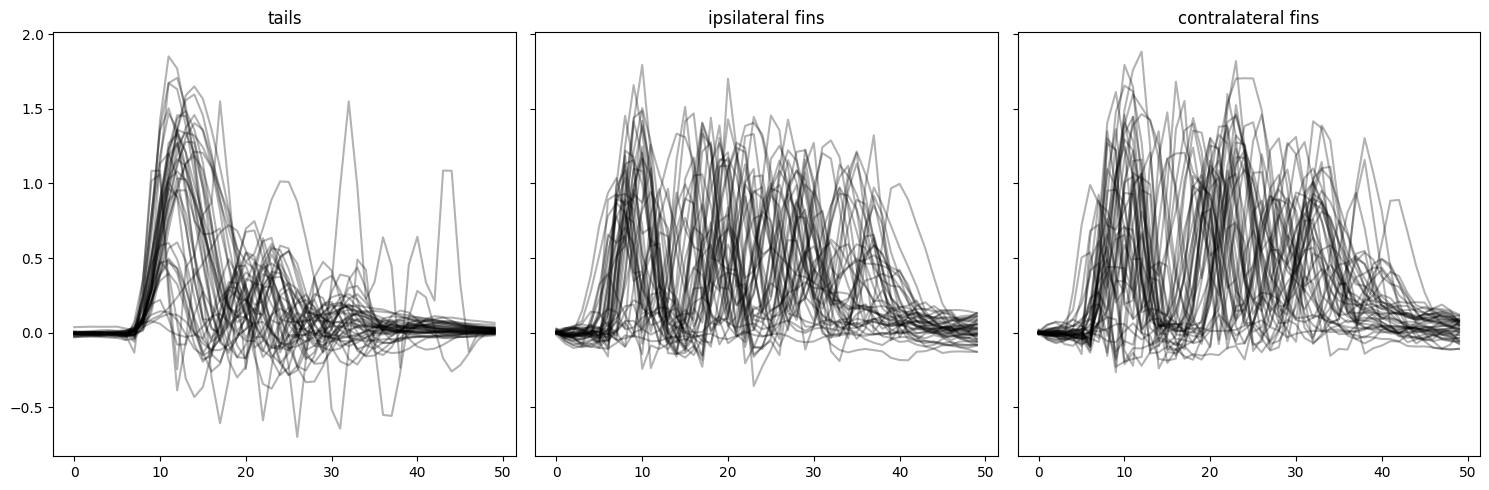

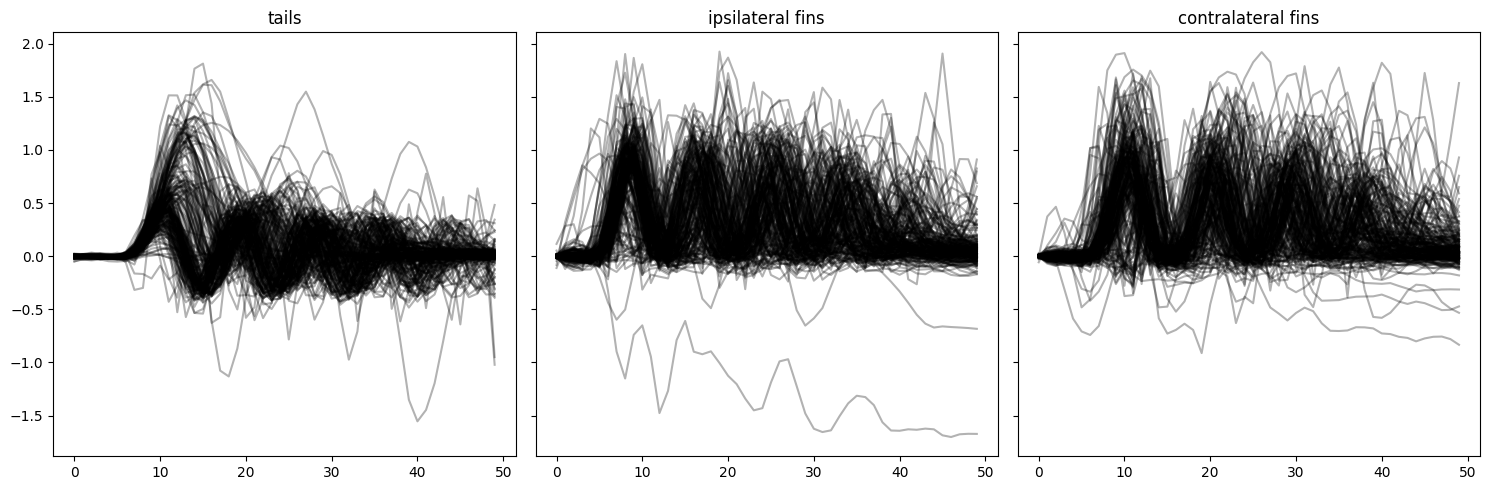

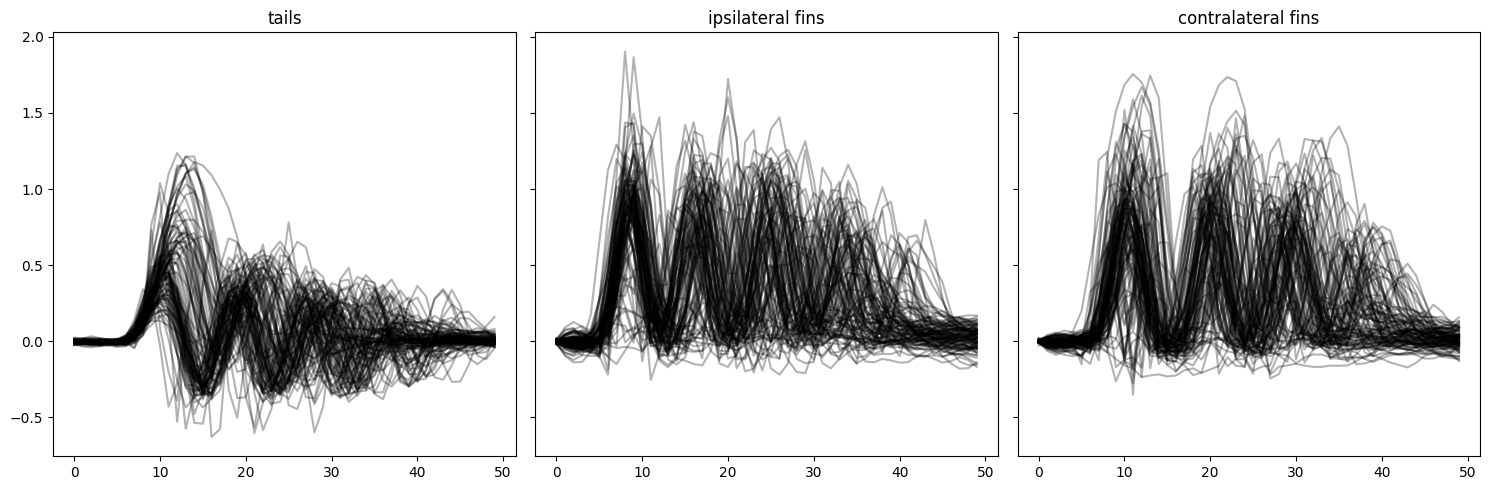

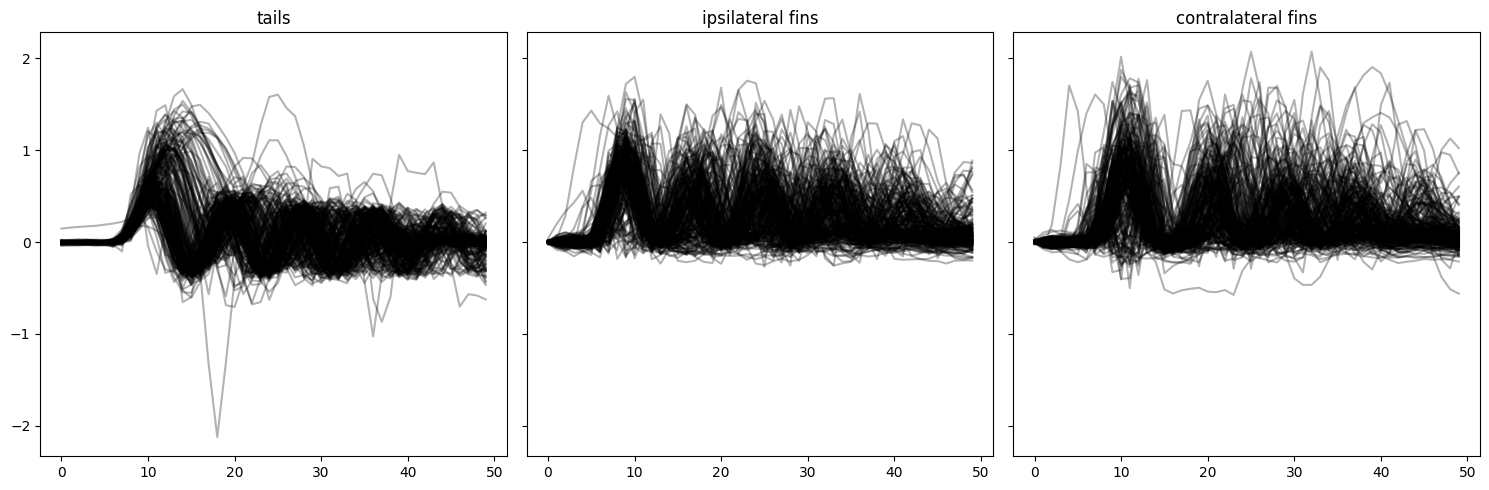

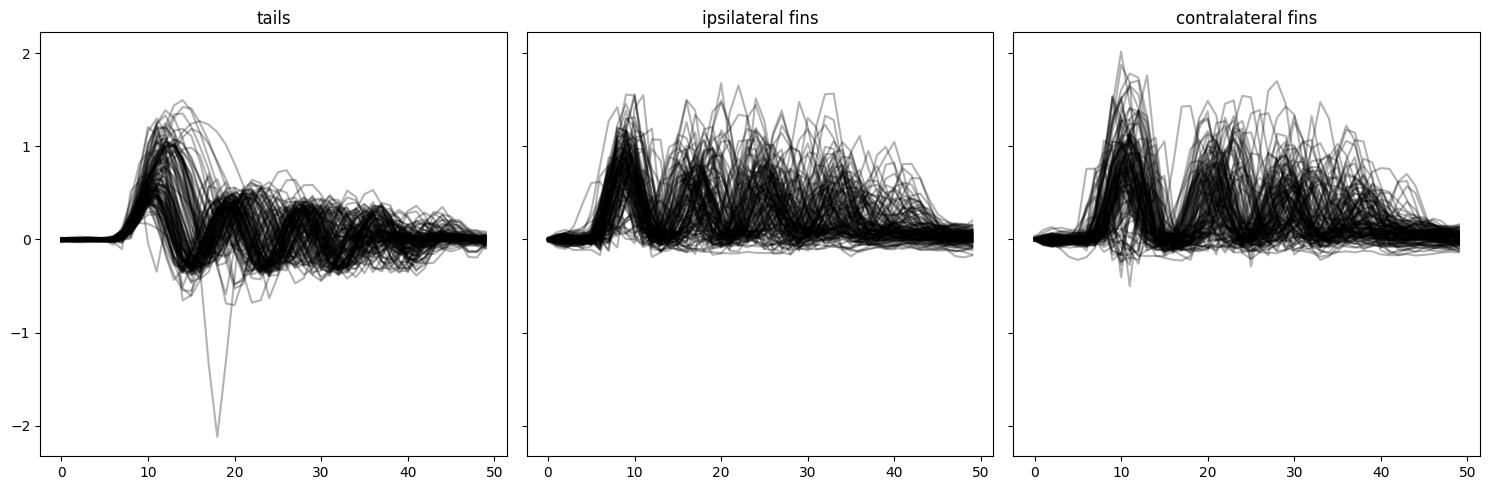

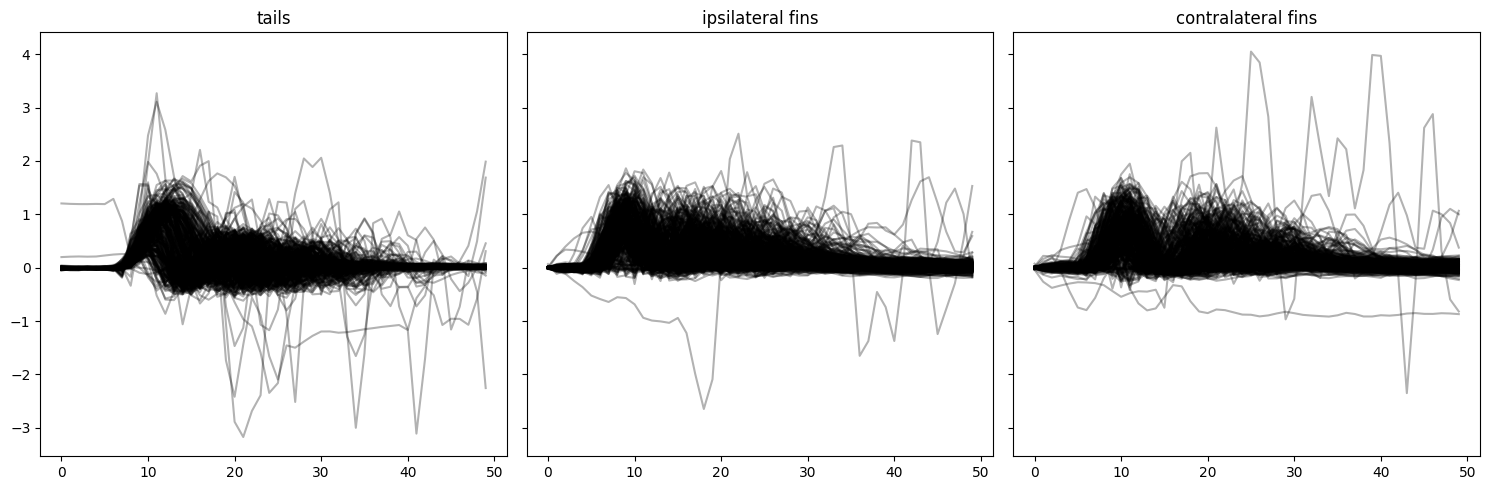

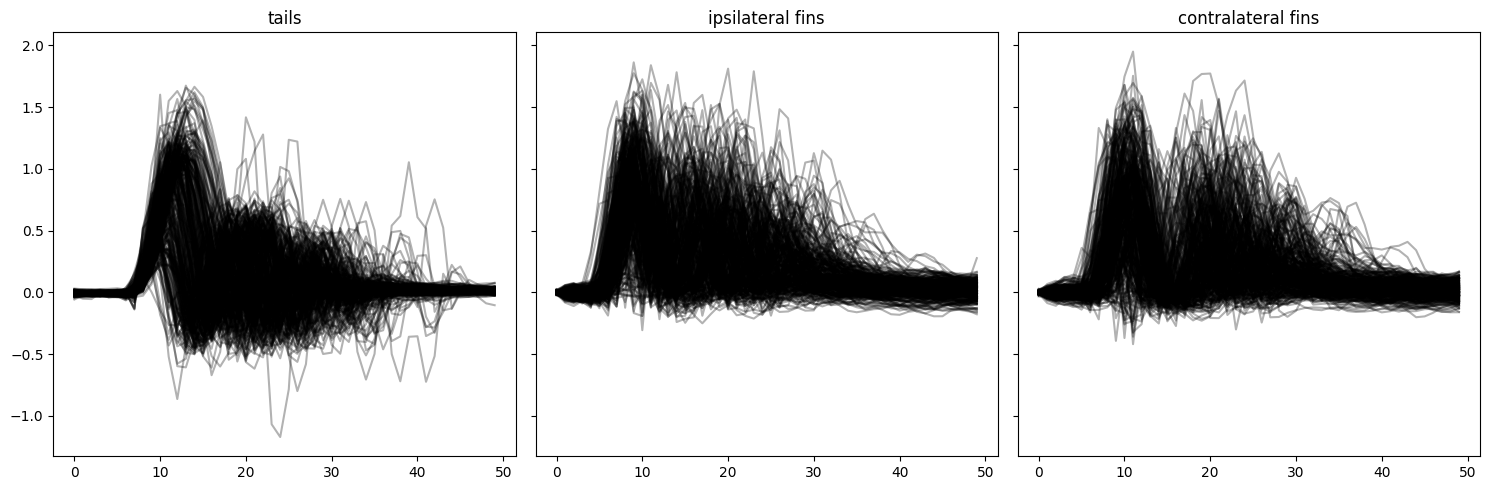

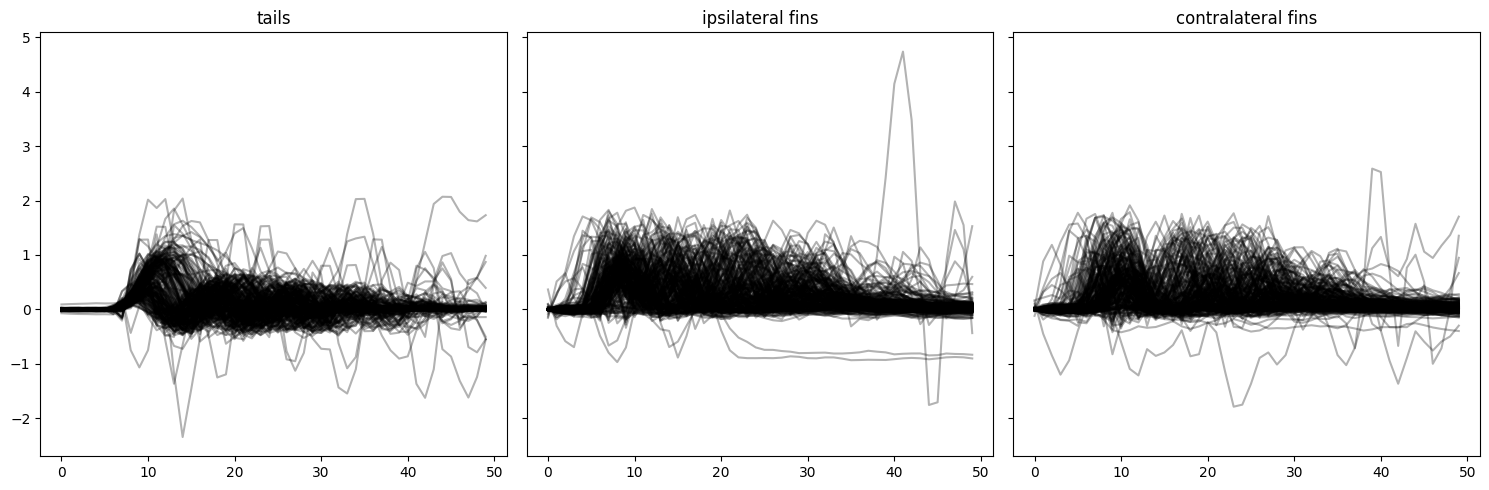

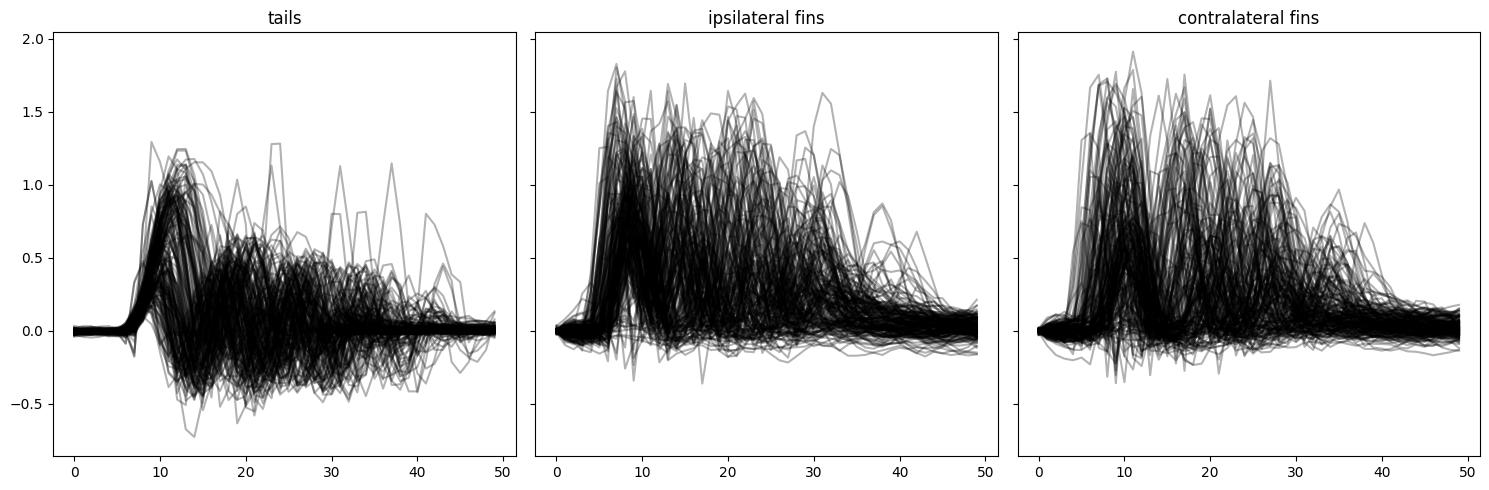

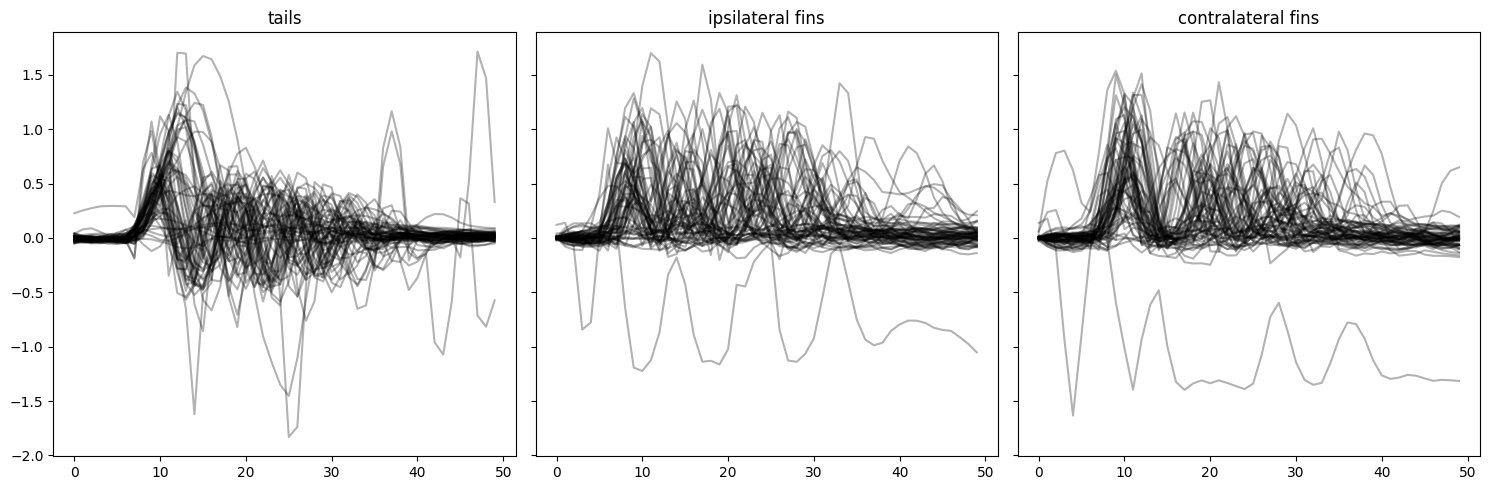

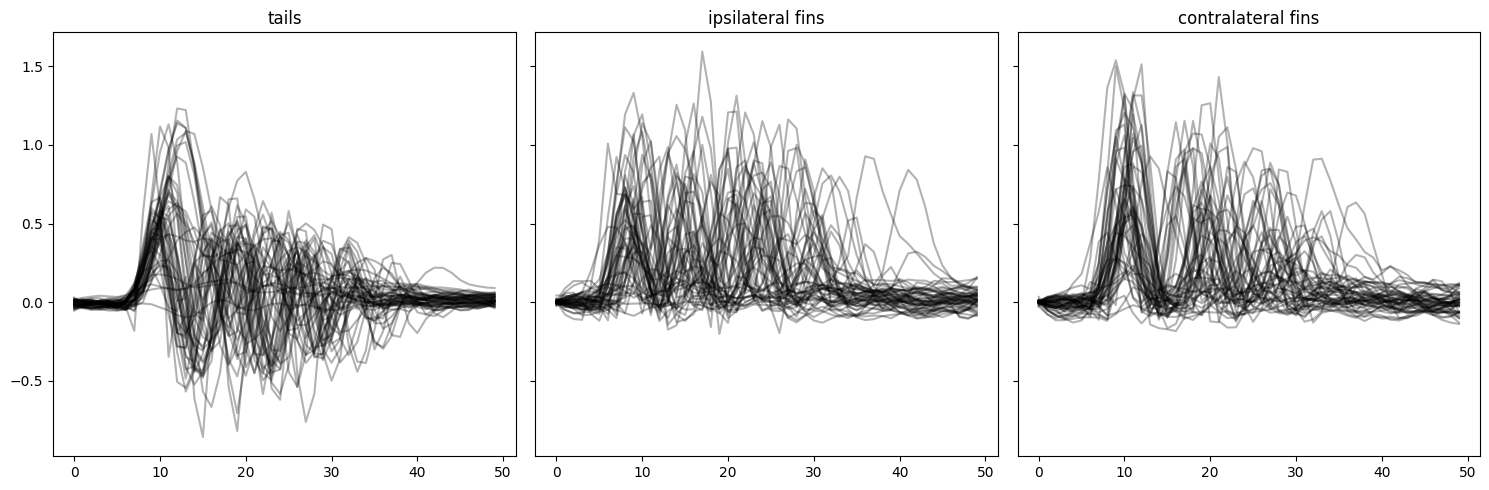

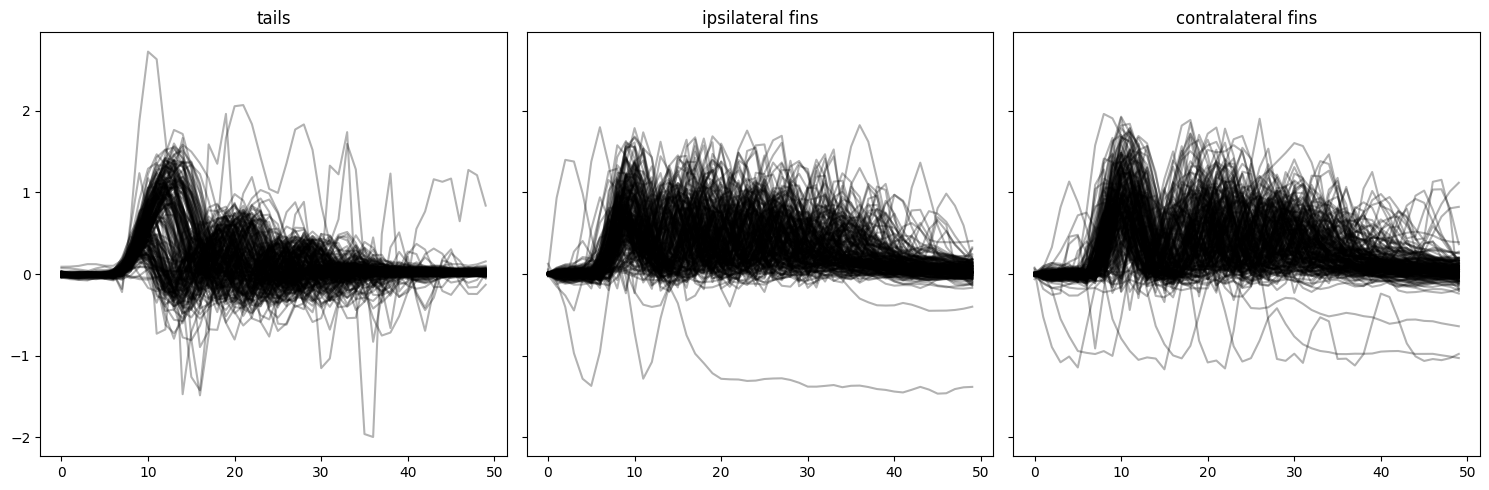

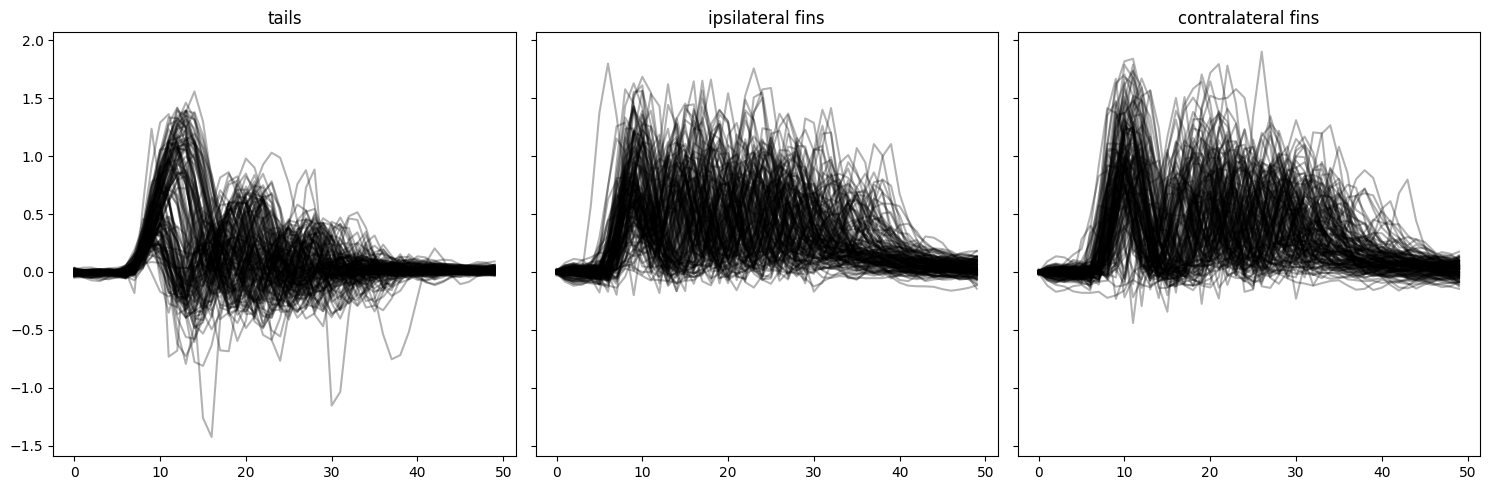

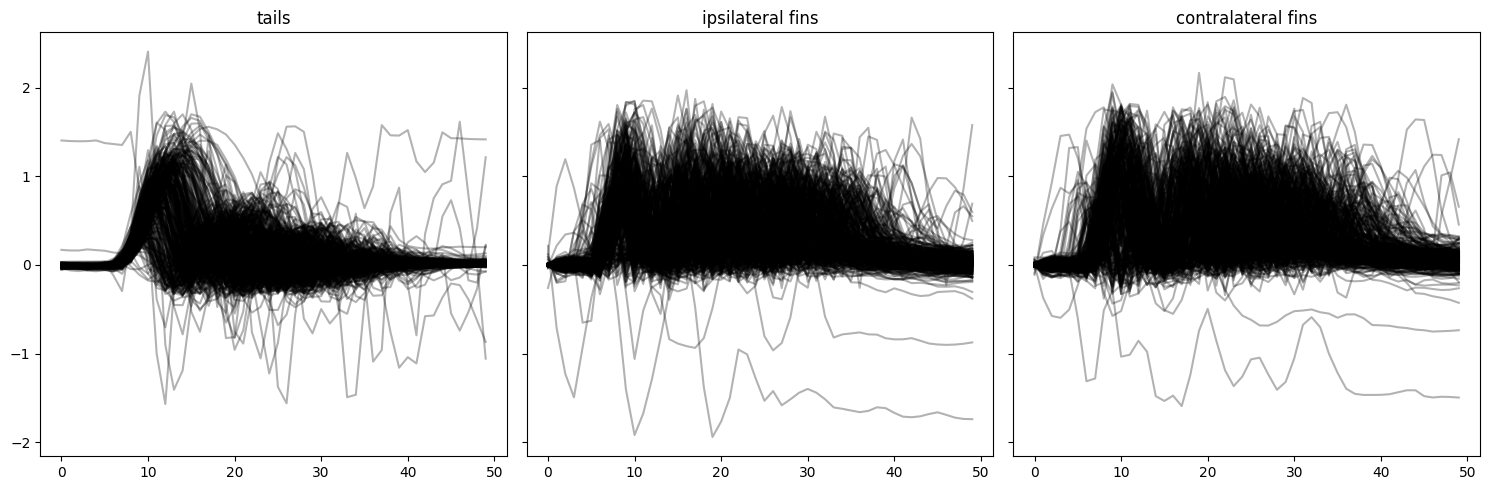

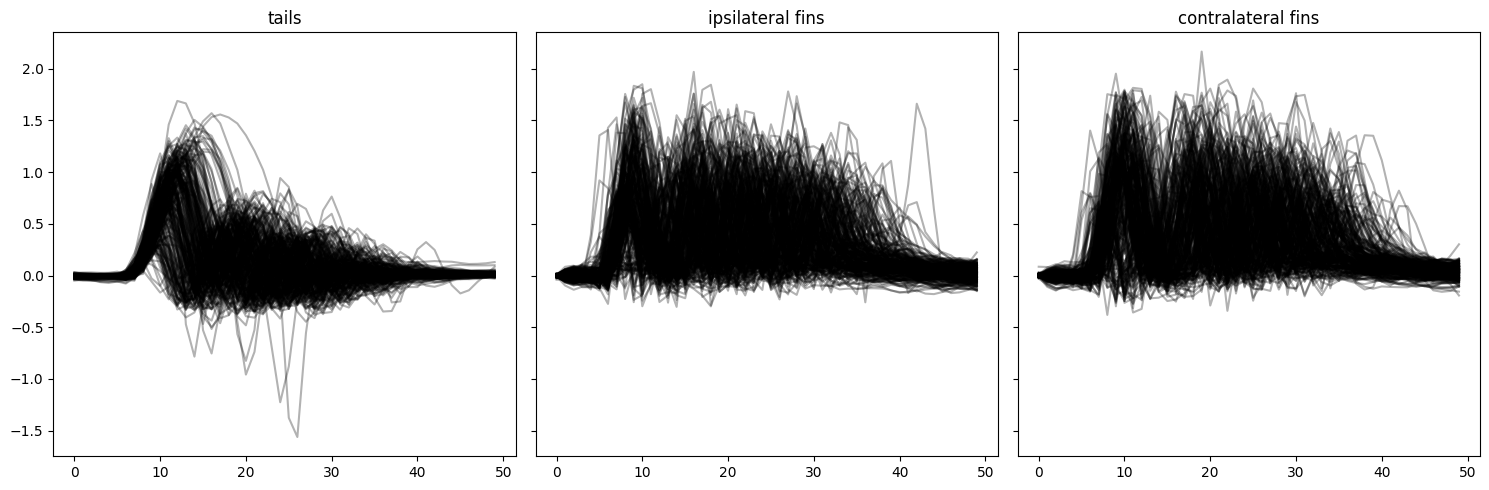

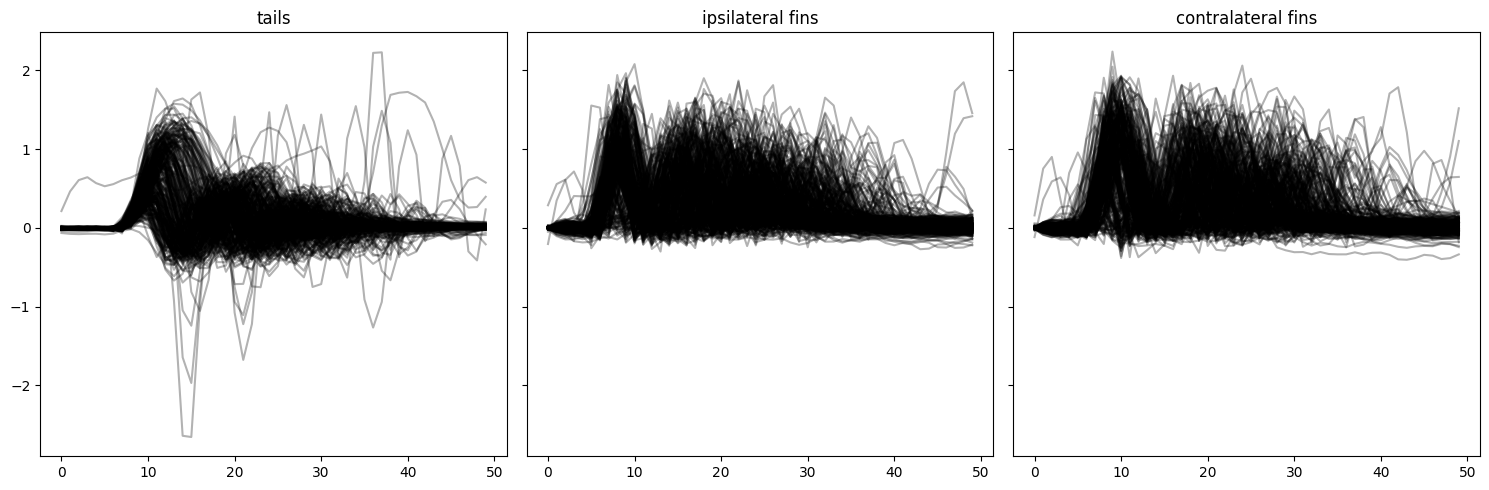

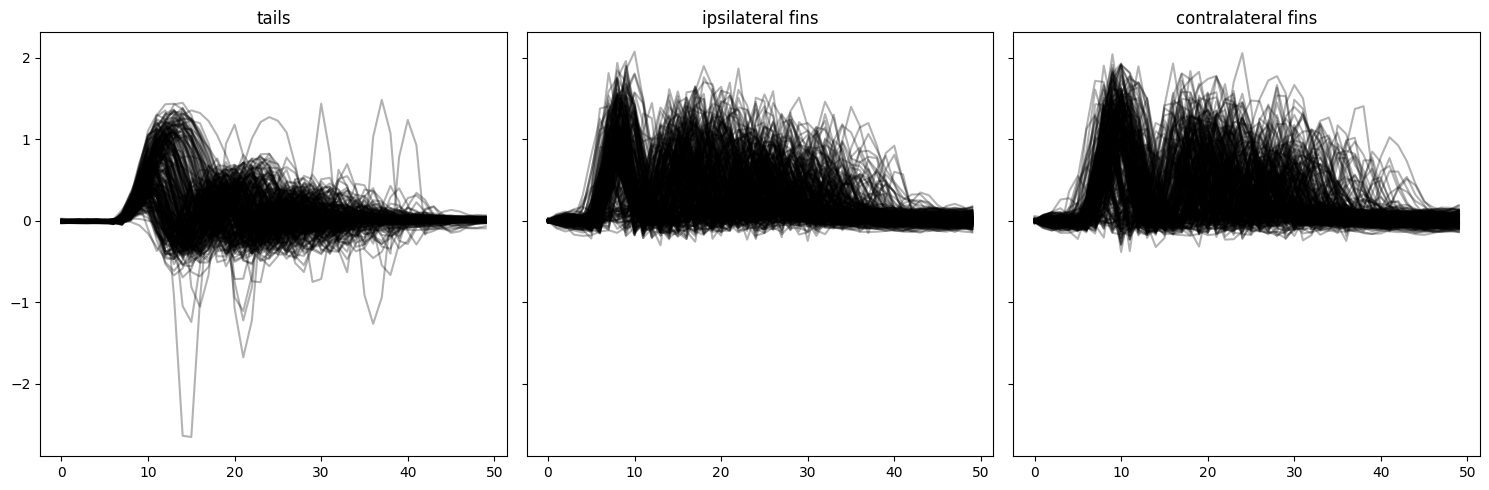

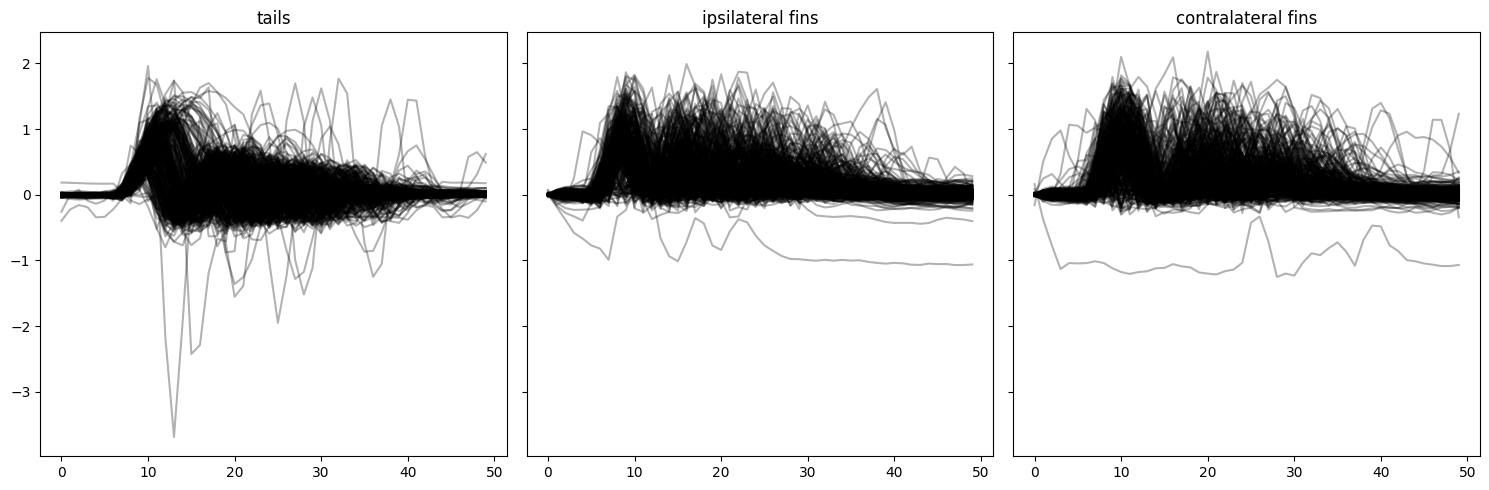

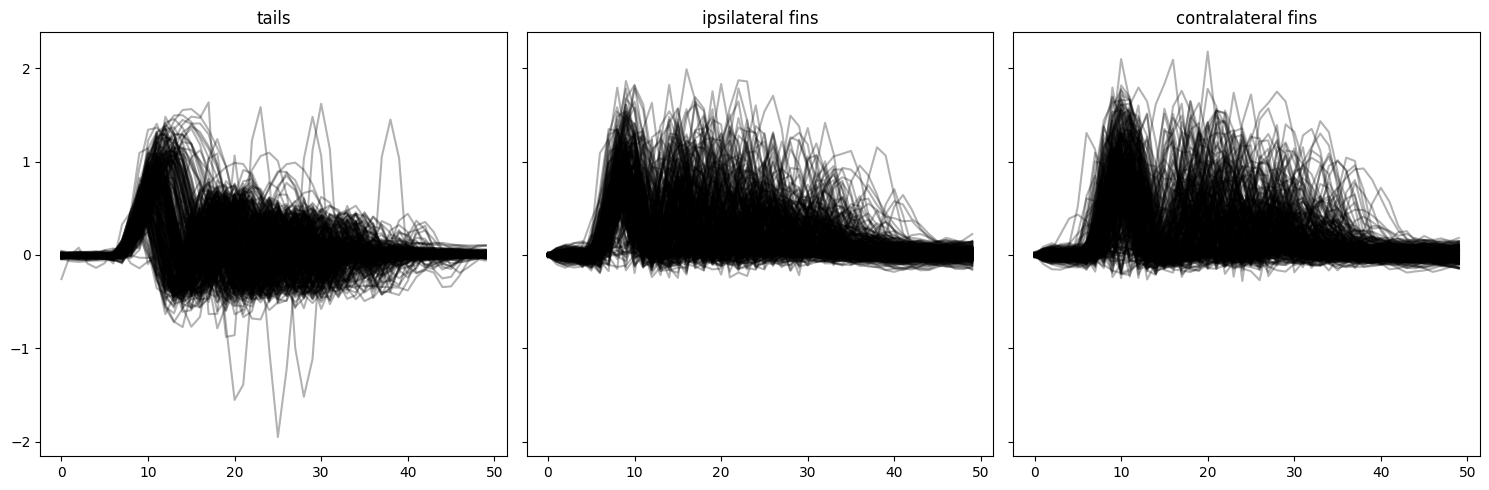

In [11]:
for ind, fish_path in enumerate(tqdm(fish_paths)):
    fish_id =  fish_path.name
    print ('Working on fish {}'.format(fish_id))
    data = fl.load(out_path/ '{}_tensor_ipsi_contra.h5'.format(fish_id))
    laterality = fl.load(out_path/ '{}_bout_laterality.h5'.format(fish_id))

    tail = data[:, 0, :]
    i_fins = data[:, 1, :]
    c_fins = data[:, 2, :]
    print (data.shape)
    
    tails, ipsi_fin, contra_fin = process_data(tail, i_fins, c_fins, laterality)

    if plot:
        fig, axes = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
        axes = axes.ravel()
        axes[0].plot(tails.T, c='k', alpha=0.3)
        axes[1].plot(ipsi_fin.T, c='k', alpha=0.3)
        axes[2].plot(contra_fin.T, c='k', alpha=0.3)
        axes[0].set_title('tails')
        axes[1].set_title('ipsilateral fins')
        axes[2].set_title('contralateral fins')
        plt.tight_layout()

    # Filter the trials
    f_tails, f_ipsi_fin, f_contra_fin, good_bouts = filter_trials( tails, ipsi_fin, contra_fin, threshold=threshold_value, baseline_points=5,  max_threshold_factor=max_threshold_factor)

    if plot:
        fig, axes = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
        axes = axes.ravel()
        axes[0].plot(f_tails.T, c='k', alpha=0.3)
        axes[1].plot(f_ipsi_fin.T, c='k', alpha=0.3)
        axes[2].plot(f_contra_fin.T, c='k', alpha=0.3)
        axes[0].set_title('tails')
        axes[1].set_title('ipsilateral fins')
        axes[2].set_title('contralateral fins')
        plt.tight_layout()

    print (' total bouts' ,tail.shape[0])
    print (' Bouts filtered', tail.shape[0] - good_bouts.sum())
    print (' bouts keps', good_bouts.sum())

    good_bouts = np.asarray(good_bouts)
    fl.save(Path(out_path/'filtered'/"{}_manual_filter_f.csv".format(fish_id)), good_bouts) #this saves goood bouts


In [43]:
print ('done')

done
